# BayFlux Analysis of command line output
By Tyler W. H. Backman

This notebook was developed to accompany the mpi command line version of BayFlux, and provides analysis and plotting of the results. You must provide the config file used to run the command line version of BayFlux, for automatic importation of settings. It will also automatically determine the number of parallel samplers by comparing the settings file to the final results.

Here is an example command to run the command line version of BayFlux from the main BayFlux git repo folder, running 4 parallel samplers. This can be run within the BayFlux Docker container (see README).

    cd command_line_example
    mpirun -n 4 bayflux example_config.yaml
    
Note: If your sampler has been resumed multiple times, this code will currently just process the final run.

In [1]:
# Specify config file
import os
path = os.path.join('..', 'command_line_example')
configFile = 'example_config.yaml'

#### Import libraries, parse config file, and import data

In [2]:
%matplotlib inline

In [3]:
from pymc import gelman_rubin
import matplotlib.pyplot as plt
import matplotlib
import cobra
import math
from cobra.flux_analysis import flux_variability_analysis
import bayflux
import pandas as pd
import numpy as np
import re
from scipy.stats import norm
import operator
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import ntpath
from cobra.sampling import MCMCACHRSampler
sns.set(style="white")
print(cobra.__version__)
pd.set_option('display.max_rows', 1000)

0.18.1


In [4]:
matplotlib.rcParams['figure.figsize'] = (16,8)

In [5]:
os.chdir(path)
# parse config file into variable configData
with open(configFile, 'r') as stream:
    try:
        configData = yaml.safe_load(stream)
    except yaml.YAMLError as exception:
        print(exception)

In [6]:
# get list of existing output files we could resume from
outputFolder = ntpath.dirname(configData['outputBaseName'])

files = os.listdir(outputFolder) 
matchingFiles = list(filter(lambda x: re.match('^' + ntpath.basename(configData['outputBaseName']) + '(\d{3}).npy$', x), files))
fileNameIntegers = [int(re.sub('^' + ntpath.basename(configData['outputBaseName']) + '(\d{3}).npy', r'\1', filename)) for filename in matchingFiles]

In [7]:
# for now, resume from the largest one only
resumeHere = max(fileNameIntegers)

# define function to generate an output filename from a number
def integerToFilename(outputBaseName, x, zfill=3):
    return outputBaseName + str(x).zfill(zfill) + '.npy'

In [8]:
sampleFilename = integerToFilename(configData['outputBaseName'], resumeHere)

In [9]:
# load samples
data = np.load(os.path.join(sampleFilename))

In [10]:
# compute from data shape the number of MPI chains
chains = int(data.shape[0] / configData['bayesianSamplesPerTask'])
print('found ' + str(chains) + ' markov chains!')

found 4 markov chains!


Now we convert this model to a bayflux ReactionNetwork, which inherets 'EnhancedReaction' objects from each cobra.Reaction, allowing us to add in atom transitions

In [11]:
cobrapymodel = cobra.io.read_sbml_model(configData['modelFile'])
model = bayflux.ReactionNetwork(cobrapymodel)
model

Name,fig3
Memory address,0x040c3511790
Number of metabolites,6
Number of reactions,8
Number of groups,0
Objective expression,1.0*d_f - 1.0*d_f_reverse_5ee53
Compartments,c


In [12]:
# Import and apply exchange fluxes from file
model.readFluxConstraints(configData['fluxBoundsFile'])

# set max flux
limit = configData['maxFlux']
for reaction in model.reactions:
    if reaction.lower_bound < -limit:
        reaction.lower_bound = -limit
    if reaction.upper_bound > limit:
        reaction.upper_bound = limit

# run FBA to confirm model works
model.optimize()

,fluxes,reduced_costs
a_b,100.0,0.0
b_ec,0.0,0.0
bc_de,0.0,-2.0
d_f,100.0,0.0
b_d,100.0,0.0
a_exchange,-100.0,-2.0
e_exchange,0.0,0.0
f_exchange,100.0,0.0


In [13]:
mcmcachr = cobra.sampling.MCMCACHRSampler(model)

In [14]:
%%time
# start by warming up with samples ignoring probability to get center
warmupSamples = mcmcachr.sample(configData['centeringSamplesPerTask'], fluxes=False, likelihood=False)
warmupSamples.shape

acceptance rate: 1.0
CPU times: user 9min 18s, sys: 0 ns, total: 9min 18s
Wall time: 9min 18s


(10000, 16)

In [15]:
# put the samples in a Pandas DF
realSamples = pd.DataFrame(data, columns=[v.name for v in model.variables])
del data

In [16]:
realSampleThinning = math.ceil(realSamples.shape[0]/100000)
realSampleThinning

1

In [17]:
allRxns = [r.id for r in model.reactions][0:4]

# uncomment to create a list of the reactions we want to plot fluxes for
# allRxns = ['PFK','EDD','AKGDH', 'G6PDH2r']

<AxesSubplot:>

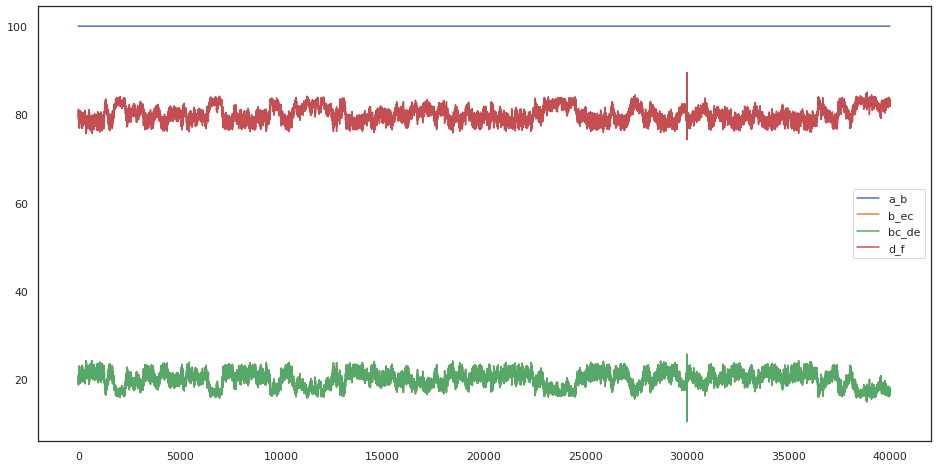

In [18]:
realSamples[allRxns].iloc[0::realSampleThinning, :].plot()
# realSamples[allRxns][-1000000:].plot()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306 UserWarning: Dataset has 0 variance; skipping density estimate.


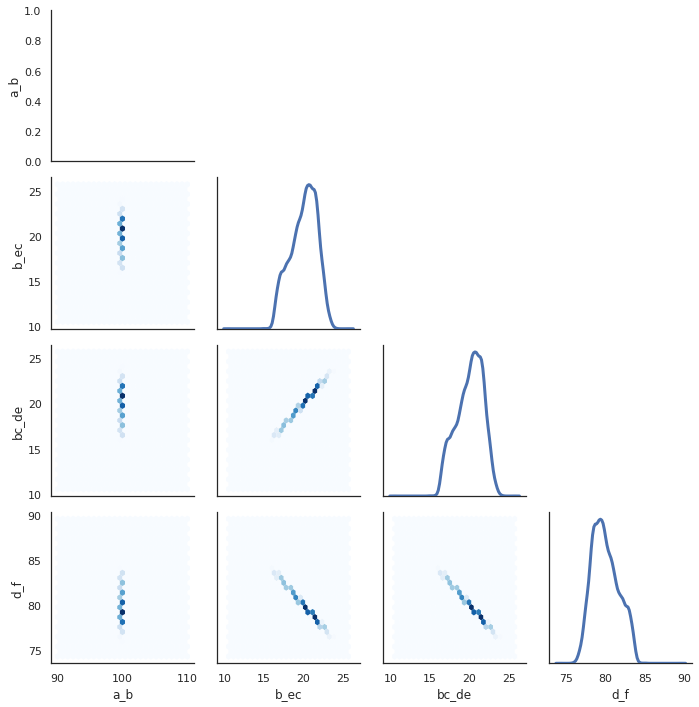

In [19]:
# plot sample distribution for samples
start = int((realSamples.shape[0]/10))
g = sns.PairGrid(realSamples[allRxns].iloc[start::realSampleThinning, :], diag_sharey=False) # plot only every 10th sample starting after sample 10k
# g = sns.PairGrid(realSamples[allRxns], diag_sharey=False)
g.map_lower(plt.hexbin, gridsize=25, cmap=plt.get_cmap('Blues'), linewidths=0)
g.map_diag(sns.kdeplot, lw=3, gridsize=100)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

### Plot marginal distributions for each reaction

Here we plot a marginal distribution for each reaction as a net flux, while excluding the first 10% of the samples, and by adding the forward and reverse fluxes to get net flux for reversible reactions.

In [20]:
# summarize the samples to be plotted

deleteStart = 0
netSamples = np.subtract(realSamples.iloc[deleteStart::1,0::2], realSamples.iloc[deleteStart::1,1::2])
netUniform = np.subtract(warmupSamples.iloc[deleteStart::1,0::2], warmupSamples.iloc[deleteStart::1,1::2])
display(netUniform.shape)
display(netSamples.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4 FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5 FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to ke

(10000, 8)

(40000, 8)

In [21]:
# remove reactions with no variance, e.g. they cannot carry flux or were fully constrained

rxnsWithVariance = netUniform.std(axis=0) > 0.001
netUniform = netUniform.loc[:,rxnsWithVariance]
netSamples = netSamples.loc[:,rxnsWithVariance]

In [22]:
netUniform.shape

(10000, 6)

In [23]:
warmupSampleThinning = math.ceil(warmupSamples.shape[0]/100000)

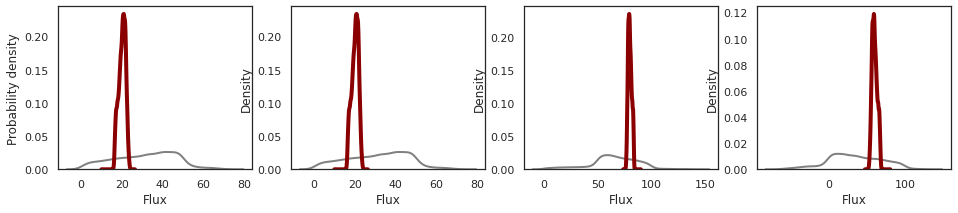

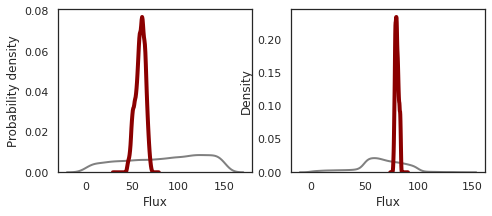

In [24]:
# plot marginals

cols = 4
rows = math.ceil(netUniform.shape[1]/cols)

matplotlib.rcParams['figure.figsize'] = (16,3)
for j in range(0, rows):
    for k in range(0, cols):
        i = (j*cols) + k
        if i > (netUniform.shape[1] - 1):
            break
        # try:
        plt.subplot(1, cols, k + 1)
        sns.kdeplot(netUniform.iloc[0::warmupSampleThinning,i], lw=2, gridsize=100, color="grey", label="Uniform")
        sns.kdeplot(netSamples.iloc[0::realSampleThinning,i], lw=4, gridsize=100, color="darkred")
        # except:
            # continue

        plt.xlabel("Flux")
        if k == 0:
            plt.ylabel("Probability density")
    plt.show()

### Analyze sampler convergence with Gelman–Rubin diagnostic

Each chain sampling from the posterior effectively starts at a different random location from a uniform sample of the flux space because of the warmupSamples, which end at a different spot depending on the random seed. Values close to 1.0 (for example 1.1 or less) typically indicate convergence.

In [25]:
samplesPerChain = configData['bayesianSamplesPerTask']

In [26]:
# compute stat with net fluxes only
# comment these out if we want to analyze each direction independently
numpysamples = np.array(realSamples)
data = np.subtract(numpysamples[:,0::2], numpysamples[:,1::2])
data.shape

(40000, 8)

In [27]:
# compute Gelman–Rubin diagnostic

# define a number of 'burn in' samples which will be discarded, and not used to compute
# the GR diagnostic
burnin = int(samplesPerChain/4) # discard the first quarter samples

# reshape data into a 3D array where each 1st dimension is a chain as used by pymc
samples = data.shape[0]
# chains = len(seeds)
data3D = np.reshape(data, newshape=(chains, samplesPerChain,-1), order='C')
thin = int(math.ceil(samplesPerChain/10))

# iteratively analyze convergence with stepsize thin
# using the gelman_rubin function from pymc
grStats = np.zeros(shape=(int((samplesPerChain - burnin)/thin), data3D.shape[2]), dtype=np.float64, order='C')
for point in range(1, int((samplesPerChain - burnin)/thin) + 1):
    thisPoint = int(point * thin) + burnin
    subset = np.take(data3D, range(burnin + 1, thisPoint), 1)
    print(subset.shape)
    grStats[point - 1] = gelman_rubin(subset)

(4, 999, 8)
(4, 1999, 8)
(4, 2999, 8)
(4, 3999, 8)
(4, 4999, 8)
(4, 5999, 8)
(4, 6999, 8)


/opt/conda/lib/python3.7/site-packages/pymc/diagnostics.py:625 RuntimeWarning: invalid value encountered in double_scalars


<AxesSubplot:>

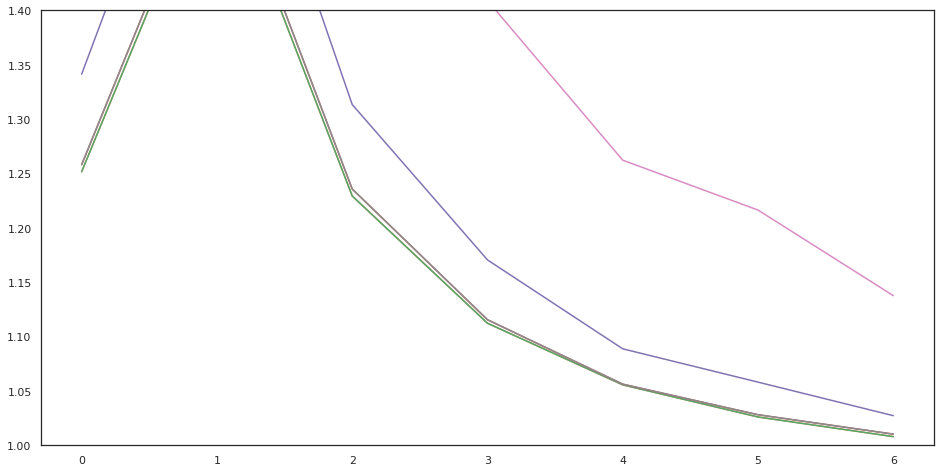

In [28]:
# plot the Gelman–Rubin diagnostic over the course of the simulation

matplotlib.rcParams['figure.figsize'] = (16,8)
# pd.DataFrame(grStats[100:,:]).plot(legend=False, ylim=(1,10))
pd.DataFrame(grStats).plot(legend=False, ylim=(1,1.4))

In [29]:
# print out final convergence by reaction name
# we drop all NAs, as they are all reverse directions for non reversible reactions
GRbyVariable = pd.DataFrame(grStats[grStats.shape[0] - 1], index=[v.name for v in model.variables][0::2], columns=['GR']).dropna()
GRbyVariable.sort_values(by='GR')

,GR
b_ec,1.007994
bc_de,1.007994
d_f,1.010280
f_exchange,1.010280
b_d,1.027258
e_exchange,1.137660


In [30]:
GRbyVariable.shape

(6, 1)

In [31]:
(GRbyVariable < 1.10).sum()

GR    5
dtype: int64